# **NEURAL NETWORK**

Classifier on the Iris dataset.

In [289]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

## **1-DATASET (Iris)**

In [ ]:
iris = datasets.load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['class'] = iris.target

iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [291]:
# Preprocessing
x = iris_df.iloc[:, :4].values  # Features
y = iris_df['class'].values      # Labels  

In [ ]:
# Normalization
def normalize(x):
    min_values = np.min(x, axis=0)
    max_values = np.max(x, axis=0)
    norm_matrix = (x - min_values) / (max_values - min_values)

    # Substitute old training data with normalized values in matrix
    x[:] = norm_matrix

normalize(x)


# Train and Test set
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)


# One-hot encoding
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.reshape(-1, 1))

print(X_train.shape)
print(y_train_encoded.shape)

(120, 4)
(120, 3)


## **2-NET** 

The net is composed by the input layer two hidden layer, and the output layer.

$$ \begin{align*}
\underset{(120, 4)}{X} \underset{(4, 8)}{W_1} + \text{b}_1 = \underset{(120, 8)}{z_1} \\
\phi_\text{ReLu} (z_1)= \underset{(120, 8)}{A_1} \\
\underset{(120, 8)}{A_1} \underset{(8, 8)}{W_2} + \text{b}_2 = \underset{(120, 8)}{z_2} \\
\phi_\text{ReLu} (z_2)= \underset{(120, 8)}{A_2} \\
A_2 \underset{(8, 3)}{W_3} + \text{b}_3 = \underset{(120, 3)}{\hat z} \\
\phi_\text{softmax} (\hat z)= \underset{(120, 3)}{\hat y}
\end{align*}$$

In [ ]:
max_epochs = 200

dim_input = 4
dim_hidden1 = 8
dim_hidden2 = 8
dim_output = 3  # Setosa, Versicolor, Virginica

learning_rate = 0.1

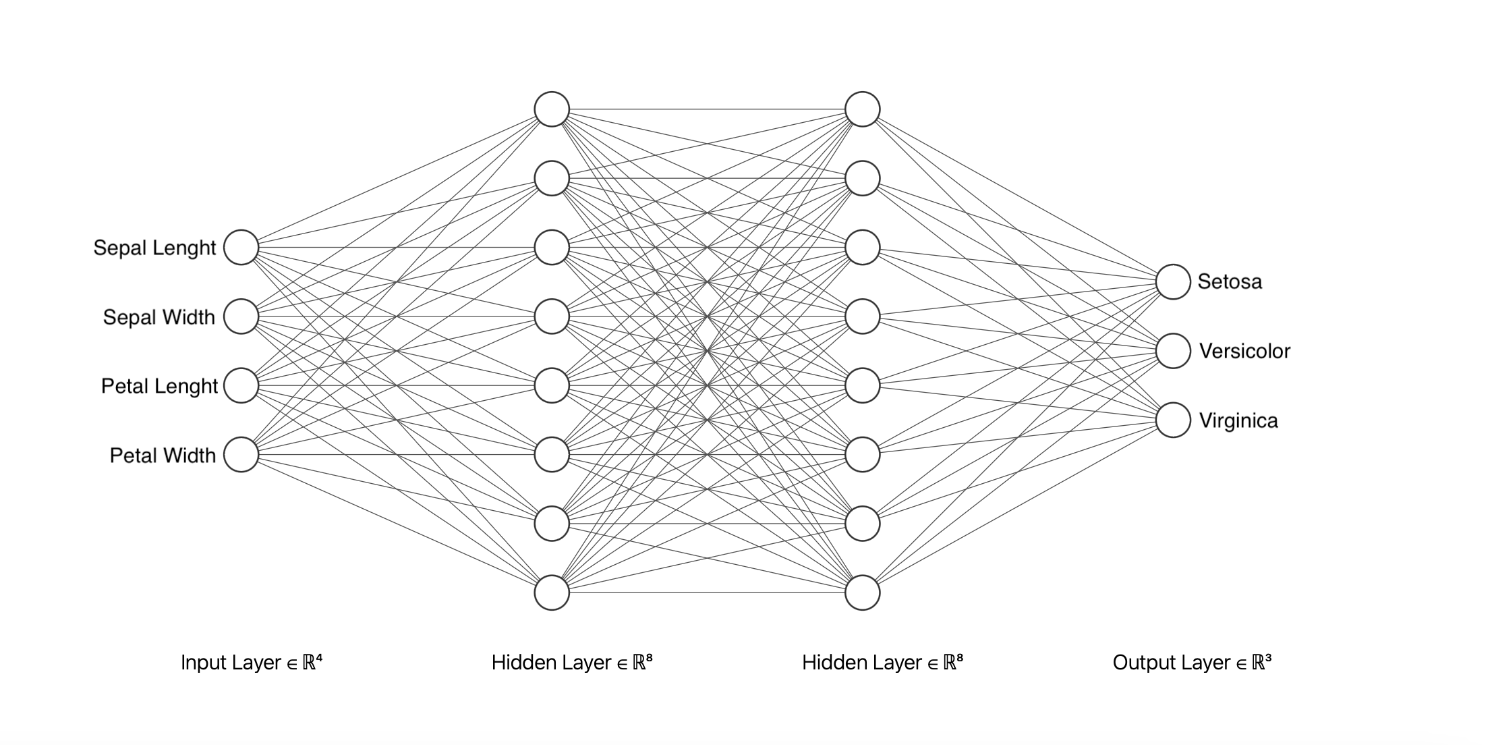

In [ ]:
class Layer:
    def __init__(self, input_size, neurons):
        # Initialize weights and biases
        self.weights = np.random.normal(0,1, (input_size, neurons))
        self.biases = np.zeros((1, neurons))
    
    def forward_propagation(self, inputs):
        # Linear transformation
        return np.dot(inputs, self.weights) + self.biases


layer1 = Layer(dim_input, dim_hidden1)  # Input layer to first hidden layer 
layer2 = Layer(dim_hidden1, dim_hidden2)  # First hidden layer to second hidden layer 
output_layer = Layer(dim_hidden2, dim_output)  # Second hidden layer to output layer

Example, weight and bias for Hidden 1:

$$
W_1=
\begin{bmatrix}
w^{(1)}{1,1} & w^{(1)}{1,2} & \dots & w^{(1)}_{1,4} \\
w^{(1)}{2,1} & w^{(1)}{2,2} & \dots & w^{(1)}_{2,4} \\
\vdots & \vdots & \ddots & \vdots \\
w^{(1)}{8,1} & w^{(1)}{8,2} & \dots & w^{(1)}_{8,4}
\end{bmatrix}

\qquad

\mathbf{b}_1=
\begin{bmatrix}
b^{(1)}_{1} & b^{(1)}_2 & \dots & b^{(1)}_{8}
\end{bmatrix}
={\mathbf{0}}
$$

Let's define the activation functions, ReLU and Softmax:

$$\phi_{\text{R}} (x) = \begin{cases}
0 & \text{if } x < 0 \\
x & \text{if } x \geq 0
\end{cases}; \quad \phi_{\text{S}} (x) = \frac{e^{x_i}}{\sum e^{x_j}} $$

In [295]:
def ReLu(x):
    return np.maximum(0, x)

def softmax(x):
    x_max = np.max(x)
    e_x = np.exp(x - x_max) 
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

Relu derivative: Matrix T/F --> 1/0

In [296]:
def ReLU_derivative(x):
    return (x > 0).astype(float) 

As loss function we'll use the cross-entropy:

$$ 
J(\hat{y}, y) = - \frac{1}{m} \sum_{m=1}^{m} \sum_{i=1}^{C} y_{m,i} \cdot \log(\hat{y}_{m,i})
$$

In [297]:
def cross_entropy(y_true, y_pred):
    return -np.mean(np.sum(y_true * np.log(np.clip(y_pred, 1e-15, 1 - 1e-15)), axis=-1))

Derivatives for backward propagation:

$$
\begin{align*}
\frac{\partial J}{\partial \hat z} &= \hat y - y \\
\frac{\partial \hat z}{\partial A_2} &= W_3^T, \quad \frac{\partial \hat z}{\partial W_3} = A_2^T; \quad \frac{\partial \hat z}{\partial \text{b}_3} = 1 \\
\frac{\partial A_2}{\partial z_2} &=
\begin{cases}
0 & \text{if } z_2 < 0 \\
1 & \text{if } z_2 \geq 0
\end{cases} \\
\frac{\partial z_2}{\partial A_1} &= W_2, \quad \frac{\partial z_2}{\partial W_2} = A_1^T; \quad \frac{\partial z_2}{\partial \text{b}_2} = 1 \\
\frac{\partial A_1}{\partial z_1} &=
\begin{cases}
0 & \text{if } z_1 < 0 \\
1 & \text{if } z_1 \geq 0
\end{cases} \\
\frac{\partial z_1}{\partial X} &= W_1^T; \quad \frac{\partial z_1}{\partial \text{b}_1} = 1 \\
\end{align*}
$$

So:

$$
\begin{align*}
\frac{\partial J}{\partial W_3} &= \frac{\partial J}{\partial \hat{z}} \cdot \frac{\partial \hat{z}}{\partial W_3} = \frac{\partial J}{\partial \hat{z}} \cdot A_2 = A_2^T \cdot \frac{\partial J}{\partial \hat{z}} \\
\frac{\partial J}{\partial W_2} &= \frac{\partial J}{\partial z_2} \cdot \frac{\partial z_2}{\partial W_2} = \left( \frac{\partial J}{\partial A_2} \odot \phi'_{\text{R}}(z_2) \right) \cdot A_1 = A_1^T \cdot \frac{\partial J}{\partial z_2} \\
\frac{\partial J}{\partial W_1} &= \frac{\partial J}{\partial z_1} \cdot \frac{\partial z_1}{\partial W_1} = \left( \frac{\partial J}{\partial A_1} \odot \phi'_{\text{R}}(z_1) \right) \cdot X = X^T \cdot \frac{\partial J}{\partial z_1}
\end{align*}
$$

$$
\begin{align*}
\frac{\partial J}{\partial A_2} &= \frac{\partial J}{\partial \hat z} \frac{\partial \hat z}{\partial A_2} = (\hat y - y) \cdot W_3^T \\
\frac{\partial J}{\partial z_2} &= \frac{\partial J}{\partial A_2} \odot \phi{\prime}_{\text{R}}(z_2) \\
\frac{\partial J}{\partial A_1} &= \frac{\partial J}{\partial z_2} \cdot \frac{\partial z_2}{\partial A_1} = \frac{\partial J}{\partial z_2} \cdot W_2^T \\
\frac{\partial J}{\partial z_1} &= \frac{\partial J}{\partial A_1} \odot \phi{\prime}_{\text{R}}(z_1)
\end{align*}
$$

Update weights:

$$\begin{cases}
W_1 \leftarrow W_1 - \eta \frac{\partial J}{\partial W_1} \\
W_2 \leftarrow W_2 - \eta \frac{\partial J}{\partial W_2} \\
W_3 \leftarrow W_3 - \eta \frac{\partial J}{\partial W_3}
\end{cases}$$

For the biases, we are just multiplying the matrix for an all-ones array (the derivative), so it is like doing an internal sum.

$$A =
\begin{bmatrix}
a_{11} & a_{12} & \dots & a_{1n} \\
a_{21} & a_{22} & \dots & a_{2n} \\
\vdots & \vdots & \ddots & \vdots \\
a_{m1} & a_{m2} & \dots & a_{mn}
\end{bmatrix}; \quad
b' =
\begin{bmatrix}
1 \\
1 \\
\vdots \\
1
\end{bmatrix}$$

Example:


$$A \cdot b' =
\begin{bmatrix}
1 & 2 & 3 \\
4 & 5 & 6 \\
7 & 8 & 9
\end{bmatrix}
\cdot
\begin{bmatrix}
1 \\
1 \\
1
\end{bmatrix}
=
\begin{bmatrix}
(1 \cdot 1) + (2 \cdot 1) + (3 \cdot 1) \\
(4 \cdot 1) + (5 \cdot 1) + (6 \cdot 1) \\
(7 \cdot 1) + (8 \cdot 1) + (9 \cdot 1)
\end{bmatrix}$$



In [ ]:
def train(X_train, y_train_encoded, layer1, layer2, output_layer, epochs, learning_rate):
    
    losses = []

    for epoch in range(epochs):  
        
        # Forward pass
        z1 = layer1.forward_propagation(X_train)
        A1 = ReLu(z1)
        z2 = layer2.forward_propagation(A1)
        A2 = ReLu(z2)
        z_hat = output_layer.forward_propagation(A2)
        y_pred = softmax(z_hat)
        
        J = cross_entropy(y_train_encoded, y_pred)
        losses.append(J)

        '''Backward Propagation'''
        samples = X_train.shape[0]

        # Gradients output
        dJ_dz_hat = y_pred - y_train_encoded
        dJ_dW3 = np.dot(A2.T, dJ_dz_hat) / samples
        dJ_db3 = np.sum(dJ_dz_hat, axis=0, keepdims=True) / samples # matrix * matrix[1] = sum
        dJ_dA2 = np.dot(dJ_dz_hat, output_layer.weights.T)
        
        # Gradients hidden 2
        dJ_dz2 = dJ_dA2 * ReLU_derivative(z2)  
        dJ_dW2 = np.dot(A1.T, dJ_dz2) / samples
        dJ_db2 = np.sum(dJ_dz2, axis=0, keepdims=True) / samples         
        dJ_dA1 = np.dot(dJ_dz2, layer2.weights.T)  

        # Gradients hidden 1
        dJ_dz1 = dJ_dA1 * ReLU_derivative(z1)  
        dJ_dW1 = np.dot(X_train.T, dJ_dz1) / samples    
        dJ_db1 = np.sum(dJ_dz1, axis=0, keepdims=True) / samples      

        # Update weights and biases
        output_layer.weights -= learning_rate * dJ_dW3
        layer2.weights -= learning_rate * dJ_dW2
        layer1.weights -= learning_rate * dJ_dW1

        output_layer.biases -= learning_rate * dJ_db3
        layer2.biases -= learning_rate * dJ_db2
        layer1.biases -= learning_rate * dJ_db1

    return losses

In [299]:
losses = train(X_train, y_train_encoded, layer1, layer2, output_layer, max_epochs, learning_rate)

In [300]:
def predict(X, layer1, layer2, output_layer):
    z1 = layer1.forward_propagation(X)
    A1 = ReLu(z1)
    z2 = layer2.forward_propagation(A1)
    A2 = ReLu(z2)
    z_hat = output_layer.forward_propagation(A2)
    y_pred = softmax(z_hat)
    return y_pred

## **3-PERFORMANCE:**

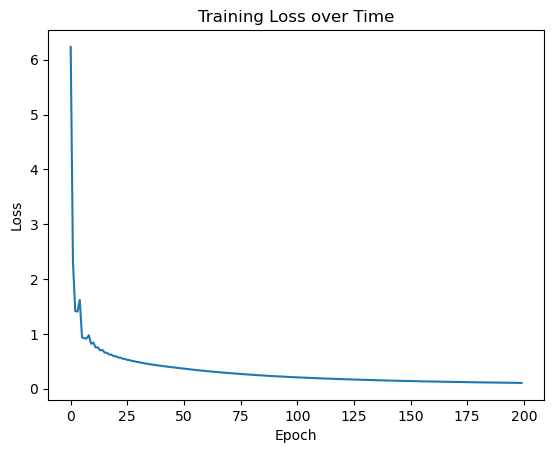

In [ ]:
def calculate_accuracy(X, y_true, layer1, layer2, output_layer):
    predictions = predict(X, layer1, layer2, output_layer)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_true, axis=1)
    return np.mean(predicted_classes == true_classes)

train_accuracy = calculate_accuracy(X_train, y_train_encoded, layer1, layer2, output_layer)
test_accuracy = calculate_accuracy(X_test, y_test_encoded, layer1, layer2, output_layer)

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Time')
plt.show()

In [302]:
test_accuracy

1.0

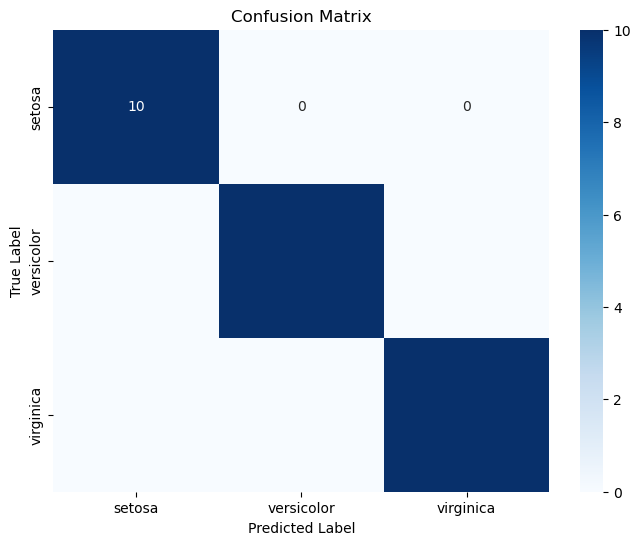

In [303]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, class_names):
    # Convert one-hot encoded labels back to class indices
    if len(y_true.shape) > 1:  # if one-hot encoded
        y_true = np.argmax(y_true, axis=1)
    if len(y_pred.shape) > 1:  # if one-hot encoded
        y_pred = np.argmax(y_pred, axis=1)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Get predictions
test_predictions = predict(X_test, layer1, layer2, output_layer)

# Plot confusion matrix
class_names = ['setosa', 'versicolor', 'virginica']
plot_confusion_matrix(y_test_encoded, test_predictions, class_names)

In [304]:
# Check the actual predictions distribution
test_predictions = predict(X_test, layer1, layer2, output_layer)
predicted_classes = np.argmax(test_predictions, axis=1)
print("Predicted class distribution:")
print(np.bincount(predicted_classes))

# Check the true labels distribution
true_classes = np.argmax(y_test_encoded, axis=1)
print("\nTrue class distribution:")
print(np.bincount(true_classes))

Predicted class distribution:
[10 10 10]

True class distribution:
[10 10 10]


The accuracy is **100%** (sometimes around 97%).